# An Impedance-based Flow Cytometer Data Analysis:
## Type Differentiation
* This is the work to use **unsupervised learning approach** for differentiating particle types from read signals
* Data are collected from lock-in amplifier input and feedback output by sensing the differential voltage amplitude due to impedance change.
* Reference signals with three different signals are tested and fed into the non-linear model to classify the outcomes.


In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)

# 1. Import data and visualization

In [2]:
alldata = pd.read_csv('type_differentiation.csv', sep=',')
alldata.head()

,bead_type,size,Frequency,Amplitude,Electrode
0,Polystyrene,10,20,1.2300,Outin
1,Polystyrene,10,20,1.0825,Outin
2,Polystyrene,10,20,1.2600,Outin
3,Polystyrene,10,20,1.0775,Outin
4,Polystyrene,10,20,1.1775,Outin


### (1) 20 MHz vs. 27 MHz Comparison 

In [3]:
label = ["Polystyrene", "Silica", "Melamine", "Fe3O4"]
data_20 = []
data_27 = []

for i in range(len(label)):
    subdata = alldata.loc[alldata.bead_type == label[i]]
    if label[i] == "Polystyrene":
        data_20.append(subdata[(subdata["size"] == 6.0) & (subdata["Frequency"] == 20.0)])
        data_27.append(subdata[(subdata["size"] == 6.0) & (subdata["Frequency"] == 27.0)])
    else:
        data_20.append(subdata[subdata["Frequency"] == 20.0])
        data_27.append(subdata[subdata["Frequency"] == 27.0])

In [4]:
data = []
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, len(label))]
for i in range(len(label)):
    chart = go.Scatter(x = data_20[i]["Amplitude"].values, 
                       y = data_27[i]["Amplitude"].values, 
                       name = label[i],
                       mode = 'markers',
                       marker = dict(
                                    size = 10,
                                    color = c[i],
                                    line = dict(width = 2)
                                )
                      )
    data.append(chart)

layout= go.Layout(
    title= '6um Bead Differentiation in Out-in Electrode',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Diff at 20MHz (uV)',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Diff at 27MHz (uV)',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)

fig = go.Figure(data=data,layout=layout)
py.iplot(fig)


### (2) Opacity (20MHz/1MHz) vs. 1MHz

In [5]:
data_1 = []
data_o = []
for i in range(len(label)):
    subdata = alldata.loc[alldata.bead_type == label[i]]
    data1 = subdata[(subdata["size"] == 6.0) & (subdata["Frequency"] == 1.0)] if label[i] == "Polystyrene" \
                                                                    else subdata[subdata["Frequency"] == 1.0]
    data_1.append(data1["Amplitude"].values)
    opacity = data_20[i]["Amplitude"].values / data1["Amplitude"].values
    data_o.append(opacity)

In [6]:
data = []
for i in range(len(label)):
    chart = go.Scatter(x = data_1[i], 
                       y = data_o[i], 
                       name = label[i],
                       mode = 'markers',
                       marker = dict(
                                    size = 10,
                                    color = c[i],
                                    line = dict(width = 2)
                                )
                      )
    data.append(chart)

layout= go.Layout(
    title= '6um Bead Differentiation in Out-in Electrode (Opacity)',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Diff at 1MHz (uV)',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Opacity (Diff at 20MHz/1MHz)',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)

fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

# 2. K-means algorithm for clustering

We first use K-means model to perform soft clustering on the unsupervised statement without showing the true label of each particle. <br>
We first show the inital data.

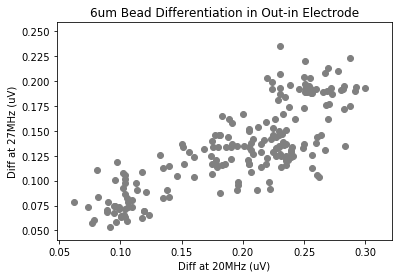

In [7]:
array = []
for i in range(len(label)):
    x = data_20[i]["Amplitude"].values
    y = data_27[i]["Amplitude"].values
    plt.scatter(x,y,c='grey')
    plt.title("6um Bead Differentiation in Out-in Electrode")
    plt.xlabel("Diff at 20MHz (uV)")
    plt.ylabel("Diff at 27MHz (uV)")
    
    data = np.array([list(x), list(y)]).T
    array.append(data)

plt.show()

X = array[0]
for i in range(1,len(array)):
    X = np.concatenate((X,array[i]), axis=0)

### Initialize centroids

$$C=\{\vec{c}_1,\vec{c}_2,\ldots,\vec{c}_k\}$$

By selecting $k$ elements at random from the data set $X$

In [8]:
def initialize_centroids(points, k):
    """returns k centroids from the initial points"""
    centroids = points.copy()
    np.random.shuffle(centroids)
    return centroids[:k]

##  The two-step K-mean algorithm

Each iteration of the $K$-means algorithm consists of two steps:
1. Associate each point $\vec{x} \in X$ to the closest center: $\vec{x} \in C_i$ where $\mbox{argmin}_i \|\vec{x} - \vec{c}_i\|_2$
2. Update each centroid to be the mean of the points in $X$ that were assigned to it:
$$ \vec{c}'_i  = \frac{1}{m} \sum_{\vec{x} \in C_i} \vec{x}$$

In [9]:
#step 1
def closest_centroid(points, centroids):
    """returns an array containing the index to the nearest centroid for each point"""
    distances = np.sqrt(((points - centroids[:, np.newaxis])**2).sum(axis=2))
    return np.argmin(distances, axis=0)

#step 2
def move_centroids(points, closest, centroids):
    """returns the new centroids assigned from the points closest to them"""
    return np.array([points[closest==k].mean(axis=0) for k in range(centroids.shape[0])])

def compute_error(points,closest,centroids):
    """ returns the RMS of the distance to the closest centroid"""
    return np.sqrt(np.mean(((points-centroids[closest,:])**2)))

## K-means in action

RMSE Error at iteration 0 is 0.023810132908151337
RMSE Error at iteration 1 is 0.018292095237987766
RMSE Error at iteration 2 is 0.01726888150305318
RMSE Error at iteration 3 is 0.01709309091435686
RMSE Error at iteration 4 is 0.01708934330710375
RMSE Error at iteration 5 is 0.01708021557690239
RMSE Error at iteration 6 is 0.017077172040960726
RMSE Error at iteration 7 is 0.017077172040960726
RMSE Error at iteration 8 is 0.017077172040960726
RMSE Error at iteration 9 is 0.017077172040960726


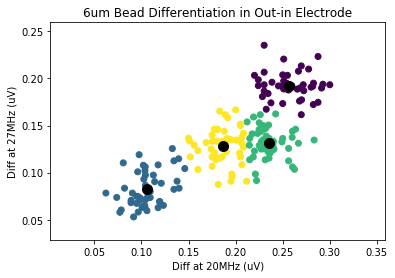

In [22]:
centroids = initialize_centroids(X, 4)
n_iters = 10
for i in range(n_iters):
    closest = closest_centroid(X, centroids)
    error=compute_error(X, closest, centroids)
    print("RMSE Error at iteration {} is {}".format(i, error))
    centroids = move_centroids(X, closest, centroids)

plt.scatter(X[:, 0], X[:, 1], c=closest)
plt.scatter(centroids[:, 0], centroids[:, 1], c='k', s=100)
plt.title("6um Bead Differentiation in Out-in Electrode")
plt.xlabel("Diff at 20MHz (uV)")
plt.ylabel("Diff at 27MHz (uV)")
plt.axis('equal')
plt.show()

In [29]:
Y = np.array([0]*50+[2]*50+[3]*50+[1]*50)
print("Accuracy: ", Y[Y == closest].shape[0] / Y.shape[0])

Accuracy:  0.91


# 3. Guassian Mixture Model with Expectation-Maximization Algorithm

We use gussian mixture model to perform soft clustering on the unsupervised statement without showing the true label of each particle. <br>
We first show the inital data.

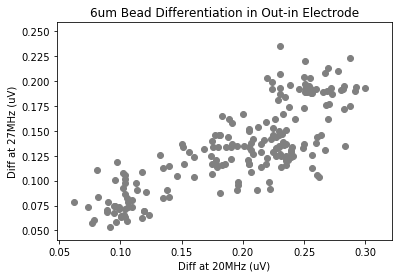

In [11]:
array = []
for i in range(len(label)):
    x = data_20[i]["Amplitude"].values
    y = data_27[i]["Amplitude"].values
    plt.scatter(x,y,c='grey')
    plt.title("6um Bead Differentiation in Out-in Electrode")
    plt.xlabel("Diff at 20MHz (uV)")
    plt.ylabel("Diff at 27MHz (uV)")
    
    data = np.array([list(x), list(y)]).T
    array.append(data)

plt.show()

X = array[0]
for i in range(1,len(array)):
    X = np.concatenate((X,array[i]), axis=0)

**Task 1**: Implement E-step for GMM

In [12]:
from scipy.stats import multivariate_normal
def E_step(X, pi, mu, sigma):
    """
    Performs E-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    pi: (C), mixture component weights 
    mu: (C x d), mixture component means
    sigma: (C x d x d), mixture component covariance matrices
    
    Returns:
    gamma: (N x C), probabilities of clusters for objects
    """
    N = X.shape[0] # number of objects
    C = pi.shape[0] # number of clusters
    d = mu.shape[1] # dimension of each object
    gamma = np.zeros((N, C)) # distribution q(T)
    
    for t in range(C):
        gamma[:,t] = multivariate_normal.pdf(X, mean=mu[t,:], cov=sigma[t,:])*pi[t]
    gamma /= np.sum(gamma,axis=1,keepdims=True)
    
    return gamma

**Task 2**: Implement M-step for GMM

In [13]:
def M_step(X, gamma):
    """
    Performs M-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    
    Returns:
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object
    mu = np.zeros((C,d))
    pi = np.zeros((C,1))
    sigma = np.zeros((C,d,d))

    for t in range(C):
        mu[t,:] = np.dot(gamma[:,t].T,X)/np.sum(gamma[:,t], axis=0, keepdims=True)
        sigma[t,:] = np.sum([gamma[i,t] * np.outer(X[i] - mu[t], X[i] - mu[t]) for i in range(N)], axis=0) / np.sum(gamma[:,t], axis=0, keepdims=True)
        pi[t] = np.sum(gamma[:,t], axis=0, keepdims=True)/N

    return pi, mu, sigma

**Task 3**: Implement variance lower bound for GMM

In [14]:
def compute_vlb(X, pi, mu, sigma, gamma):
    """
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    
    Returns value of variational lower bound
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object
    first = np.zeros((C,1))
    loss = 0
    
    first = [np.dot(gamma[:,t].T,multivariate_normal.logpdf(X, mean=mu[t,:], cov=sigma[t,:], allow_singular=True)+np.log(pi[t]+0.000001)) for t in range(C)]
    second = np.sum(gamma*np.log(gamma))
    loss = np.sum(first) - second
    
    return loss

**Task 4**: Train E-step and M-step for the model

In [18]:
import math
def train_EM(X, C, rtol=1e-4, max_iter=100, restarts=10):
    '''
    Starts with random initialization *restarts* times
    Runs optimization until saturation with *rtol* reached
    or *max_iter* iterations were made.
    
    X: (N, d), data points
    C: int, number of clusters
    '''
    N = X.shape[0] # number of objects
    d = X.shape[1] # dimension of each object
    best_loss = 0
    best_pi = None
    best_mu = None
    best_sigma = None

    for _ in range(restarts):
        try:
            pi = np.array([1.0/C]*C,dtype=np.float32)
            mu = np.random.rand(C, d)
            sigma_ = np.random.rand(C, d, d)
            sigma = np.array([np.dot(A, A.T) for A in sigma_])
            prev_loss = None
            for i in range(max_iter):
                gamma = E_step(X, pi, mu, sigma)
                pi, mu, sigma = M_step(X, gamma)
                loss = compute_vlb(X, pi, mu, sigma, gamma)
                if not math.isnan(loss) and loss > best_loss:
                    best_loss = loss
                    best_mu = mu
                    best_pi = pi
                    best_sigma = sigma
                print("Iteration {}, loss: {}".format(i, loss))

                if prev_loss is not None:
                    diff = np.abs(loss - prev_loss)
                    if diff < rtol:
                        break
                prev_loss = loss

        except: # np.linalg.LinAlgError:
            print("Singular matrix: components collapsed")
            pass

    return best_loss, best_pi, best_mu, best_sigma

In [23]:
best_loss, best_pi, best_mu, best_sigma = train_EM(X, 3)

Iteration 0, loss: 726.9733838126913
Iteration 1, loss: nan
Iteration 2, loss: nan
Singular matrix: components collapsed
Iteration 0, loss: 736.2418191119344
Iteration 1, loss: 744.7156232069797
Iteration 2, loss: 749.6705565973509
Iteration 3, loss: 752.9712008369274
Iteration 4, loss: 755.0090409563334
Iteration 5, loss: 756.2597100315763
Iteration 6, loss: 757.0414074800649
Iteration 7, loss: 757.5359030945422
Iteration 8, loss: 757.8501680001405
Iteration 9, loss: 758.0533685750275
Iteration 10, loss: 758.1937230438261
Iteration 11, loss: 758.3050779830008
Iteration 12, loss: 758.40942760636


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning:

divide by zero encountered in log

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in multiply



Iteration 13, loss: 758.5177980920552
Iteration 14, loss: 758.6317937529067
Iteration 15, loss: 758.7474905877848
Iteration 16, loss: 758.859991425541
Iteration 17, loss: 758.9658702475258
Iteration 18, loss: 759.0633773235751
Iteration 19, loss: 759.151875345925
Iteration 20, loss: 759.2313880790539
Iteration 21, loss: 759.3023665707385
Iteration 22, loss: 759.3655561365622
Iteration 23, loss: 759.4218905496504
Iteration 24, loss: 759.4723990636833
Iteration 25, loss: 759.5181329455978
Iteration 26, loss: 759.5601169880565
Iteration 27, loss: 759.599325580902
Iteration 28, loss: 759.6366793108751
Iteration 29, loss: 759.6730574191041
Iteration 30, loss: 759.7093226541734
Iteration 31, loss: 759.746357119548
Iteration 32, loss: 759.7851101943836
Iteration 33, loss: 759.826662582602
Iteration 34, loss: 759.8723145348407
Iteration 35, loss: 759.9237123367108
Iteration 36, loss: 759.9830371753601
Iteration 37, loss: 760.053298027806
Iteration 38, loss: 760.138802002215
Iteration 39, loss:

Iteration 21, loss: 760.0347365717826
Iteration 22, loss: 760.4678696126626
Iteration 23, loss: 761.1004685299071
Iteration 24, loss: 762.0680897765345
Iteration 25, loss: 763.5411185303104
Iteration 26, loss: 765.6311101569278
Iteration 27, loss: 768.4487257635185
Iteration 28, loss: 772.4230164393757
Iteration 29, loss: 777.9157615305065
Iteration 30, loss: 782.3619926199325
Iteration 31, loss: 783.9077690238005
Iteration 32, loss: 784.4350364484937
Iteration 33, loss: 784.8837128193518
Iteration 34, loss: 785.502644355103
Iteration 35, loss: 786.3917475228108
Iteration 36, loss: 787.3606155191661
Iteration 37, loss: 787.9764515248681
Iteration 38, loss: 788.2238244438124
Iteration 39, loss: 788.316975199086
Iteration 40, loss: 788.3587893143612
Iteration 41, loss: 788.3803653040358
Iteration 42, loss: 788.3923253595051
Iteration 43, loss: 788.3993051867303
Iteration 44, loss: 788.4036079000559
Iteration 45, loss: 788.4064328210932
Iteration 46, loss: 788.4084169603959
Iteration 47, 

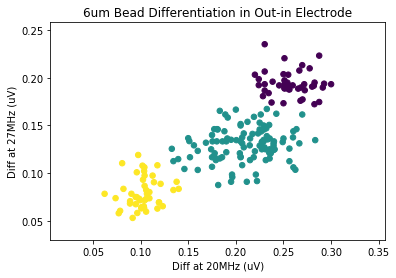

In [25]:
gamma = E_step(X, best_pi, best_mu, best_sigma)
labels = gamma.argmax(1)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=30)
plt.axis('equal')
plt.title("6um Bead Differentiation in Out-in Electrode")
plt.xlabel("Diff at 20MHz (uV)")
plt.ylabel("Diff at 27MHz (uV)")
plt.show()